In [1]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

import obe_jax as obj

import matplotlib.pyplot as plt
%matplotlib inline

# Fitting noisy data Ramsey data

Assume we have a qubit with unknown frequency $\omega$, unknown $T_2$ time, where single-shot
measurement noise that is gaussian with an unknown standard deviation $\sigma$. 

Experimentally, we apply a $\pi/2$ pulse, wait some duration $\tau$, and apply another $\pi/2$ pulse before measuring in the standard $z$ basis. 

$$|0> ---\bigg[\frac{\pi}{2}\bigg]---\bigg[\text{Idle for }\tau\bigg]---\bigg[\frac{\pi}{2}\bigg] --- [\text{Measure Z basis}] == > \text{0 or 1}$$

Assume we have an estimate to the probability of $0$ after repeating many measurements. In this case the probability should 

$$P(\tau) = \exp^{-\frac{\tau}{T_2}}\cos(\frac{\omega}{2}\tau)^2+\frac{1-\exp^{-\frac{\tau}{T_2}}}{2}$$


Also, let's assume that there is Gaussian noise with mean $P(\tau)$ and standard deviation $\sigma$.

Our task is to observe $P(\tau)$ for different inputs $\tau$ and infer, $\omega$, $T_2$, $\sigma$ from the data.

### First we will define the true parameters that we are attempting to infer


In [2]:
ω = 1.15
T2 = 75.3
σ = 0.02
true_params = jnp.asarray([ω,T2,σ])

### Next we define the likelihood of observing an output $P(\tau)$ given an input $\tau$ and a set of model parameters

In [4]:
@jax.jit
def p_mean(tau,w,T2):
    return jnp.exp(-tau/T2)*jnp.square((jnp.cos(w*tau/2)))+(1-jnp.exp(-tau/T2))/2

p_means = jax.jit(jax.vmap(p_mean,in_axes=(0,None,None))) # Vectorizing the mean function for future plotting convenience

@jax.jit
def likelihood_function(oneinput_vector,oneoutput_vector,oneparameter_vector):
    tau = oneinput_vector[0]
    w,T2,sigma = oneparameter_vector
    yout = oneoutput_vector[0]
    
    mu = p_mean(tau,w,T2)
    p = jnp.exp(-0.5*((mu-yout)/sigma)**2)/(jnp.sqrt(jnp.pi*2)*sigma) # Gaussian noise function
    return p

### Next we define our initial guess regarding possible values of $\omega$, $T_2$, and $\sigma$

### I.e., our "prior" knowledge

In [5]:
key = jax.random.PRNGKey(123)
key, subkey = jax.random.split(key)
N_particles = 10000
mins = jnp.array([1., 50, 0.00])
maxs = jnp.array([3.5, 200, 0.1])
prior_particles = obj.priors.uniform_prior_particles(subkey,mins,maxs,N_particles)
prior_weights = jnp.full((N_particles,),1/N_particles)

### And define the potential outputs we may observe

In [6]:
N_outcomes = 1000
expected_outcomes = jnp.linspace(0,1,N_outcomes).reshape((1,N_outcomes))

### Now we define our Bayseian model

In [68]:
key,subkey = jax.random.split(key)
pdf = obj.AbstractBayesianModel(subkey,prior_particles, prior_weights, expected_outcomes,
                                likelihood_function=likelihood_function, 
                                tuning_parameters = {'resample_threshold':0.5,'auto_resample':True})

In [69]:
pdf.mean()

Array([2.23373115e+00, 1.25471779e+02, 5.03309302e-02], dtype=float64)

### Next we will generate a synthetic dataset and visualize it

In [84]:
N_data_points = 50

In [85]:
#### TRY DIFFERENT SAMPLINGS OF INITIAL POINTS TO SEE INTERESTING EFFECTS:
### Uniform random initial points
# key,subkey = jax.random.split(key)
# inputs = jax.random.uniform(subkey,minval=0.001,maxval=200., shape=(N_data_points,)).reshape((1,N_data_points))

## Sequential initial points
#inputs = jnp.linspace(0.001,200.0,N_data_points).reshape((1,N_data_points))

### Exponentially random initial points
key,subkey = jax.random.split(key)
inputs = jax.random.exponential(subkey, shape=(N_data_points,)).reshape((1,N_data_points))*50

In [86]:
outputs = pdf.sample_outputs(inputs,true_params)

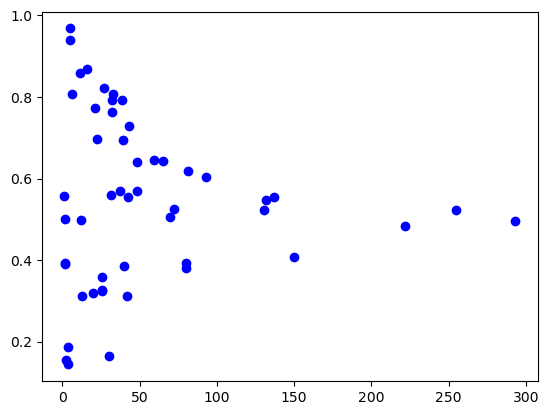

In [87]:
fig, ax = plt.subplots(1,1)
ax.plot(inputs[0,:],outputs[0,:],'bo')
plt.show()

### Now we will infer the systems parameters

In [88]:
for i in range(N_data_points):
    pdf.bayesian_update(inputs[:,i],outputs[:,i])
    
# Alternatively:
# pdf.batch_bayesian_updates(inputs,outputs) Does the same loop for you. 

In [89]:
pdf.mean()

Array([1.15020534e+00, 7.55759105e+01, 1.97406309e-02], dtype=float64)

In [90]:
pdf.covariance()

Array([[ 2.03945544e-07, -4.01745787e-05,  2.20445867e-08],
       [-4.01745787e-05,  4.90173189e+00, -6.45055454e-04],
       [ 2.20445867e-08, -6.45055454e-04,  4.55719464e-06]],      dtype=float64)

In [91]:
true_params

Array([1.15e+00, 7.53e+01, 2.00e-02], dtype=float64)

# Mean squared error after learning

In [92]:
(true_params-pdf.mean())**2

Array([4.21625855e-08, 7.61265788e-02, 6.72723292e-08], dtype=float64)

## Visualize the posterior distribution

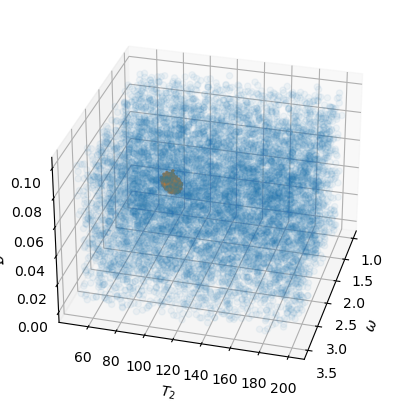

In [93]:
fig, ax = plt.subplots(1,1,subplot_kw={"projection": "3d"},figsize=(5,5))
ax.scatter(prior_particles[0,:], prior_particles[1,:], prior_particles[2,:],alpha=0.05)
ax.scatter(pdf.particles[0,:], pdf.particles[1,:], pdf.particles[2,:],s=pdf.weights*1e4)


ax.set(xlabel=r"$\omega$",
       ylabel=r"$T_2$",
       zlabel=r"$\sigma$")

ax.view_init(azim=15, elev=30)

plt.show()

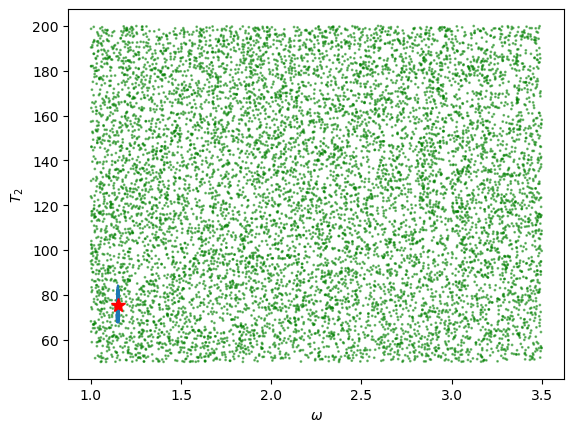

In [94]:
fig, ax = plt.subplots(1,1)
ax.scatter(prior_particles[0,:],prior_particles[1,:],s=prior_weights*1e4,color='green',alpha=0.5)
ax.scatter(pdf.particles[0,:],pdf.particles[1,:],s=pdf.weights*1e4)
ax.plot(true_params[0],true_params[1],"r*",ms=10)
ax.set_xlabel(r"$\omega$")
ax.set_ylabel(r"$T_2$")
plt.show()

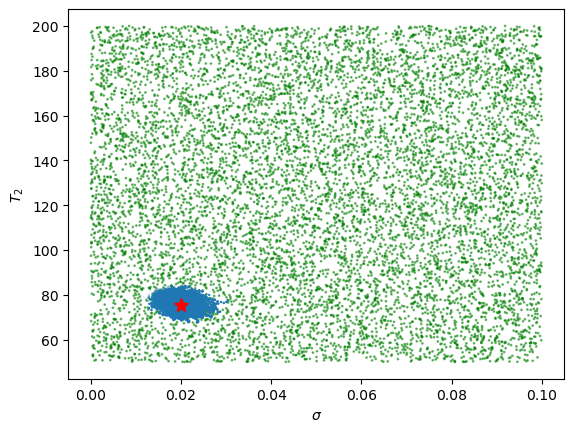

In [95]:
fig, ax = plt.subplots(1,1)
ax.scatter(prior_particles[2,:],prior_particles[1,:],s=prior_weights*1e4,color='green',alpha=0.5)
ax.scatter(pdf.particles[2,:],pdf.particles[1,:],s=pdf.weights*1e4)
ax.plot(true_params[2],true_params[1],"r*",ms=10)
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$T_2$")
plt.show()

In [96]:
## Visualize the possible particles without noise

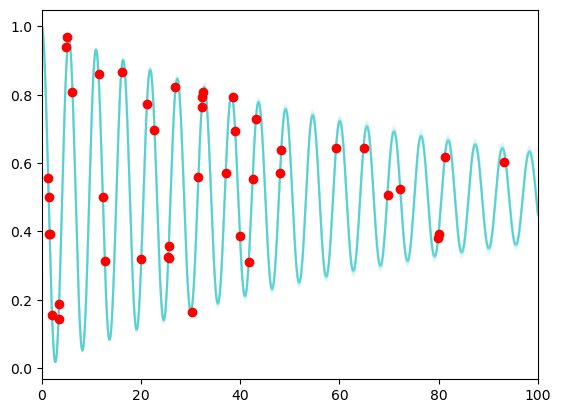

In [97]:
fig, ax = plt.subplots(1,1)
n_plots = 10
ts = jnp.linspace(0,200,100000)
for i in range(n_plots):
    part = pdf.randdraw()
    w,T2,sigma = part
    outs = p_means(ts,w,T2)
    ax.plot(ts,outs[:,0],'-',c='c',alpha=0.1)
    
ax.plot(inputs[0,:],outputs[0,:],'ro')
ax.set_xlim(0,100)
plt.show()